In [1]:
import os
from random import random
from time import sleep, time
from datetime import datetime

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import torch.nn as nn
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
DATASET_FOLDER_PATH = '/Users/aref/dvs-dataset/DvsGesture'

nb_image_height = 64
nb_image_weight = 64
nb_inputs  = nb_image_height*nb_image_weight
nb_hidden  = 128
nb_outputs = 12

time_step = 1e-3
nb_steps  = 100

batch_size = 16

In [3]:
dtype = torch.float

if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")

using cpu...


In [4]:
# Load file list:
train_trail_file = 'trials_to_train.txt'
test_trail_file = 'trials_to_test.txt'

def load_trail_files(trail_file):
    file_list = []
    with open(os.path.join(DATASET_FOLDER_PATH, trail_file), 'r') as f:
        for line in f.readlines():
            aedat_file = line.strip()
            if not line:
                continue
            csv_file = aedat_file.replace('.aedat', '_labels.csv')
            file_list.append((
                os.path.join(DATASET_FOLDER_PATH, aedat_file),
                os.path.join(DATASET_FOLDER_PATH, csv_file)
            ))
    return file_list

file_list_train = load_trail_files(train_trail_file)
file_list_test = load_trail_files(test_trail_file)

def get_label(event_labels, timestamp):
    for t in event_labels.keys():
        if t > timestamp:
            return event_labels[t]
    return 0

def get_label_text(event_labels, timestamp):
    return gesture_mapping[get_label(event_labels, timestamp)]

# mapping
gesture_mapping = {
    0: 'no_gesture',
    1: 'hand_clapping',
    2: 'right_hand_wave',
    3: 'left_hand_wave',
    4: 'right_arm_clockwise',
    5: 'right_arm_counter_clockwise',
    6: 'left_arm_clockwise',
    7: 'left_arm_counter_clockwise',
    8: 'arm_roll',
    9: 'air_drums',
    10: 'air_guitar',
    11: 'other_gestures',
}

In [5]:
_last_time_length = None
_iteration_left = None

def time_unit_creator(l_time):
    time_unit = 'seconds'
    if l_time >= 60:
        l_time /= 60
        time_unit = 'minutes'
    else:
        return l_time, time_unit
    
    if l_time >= 60:
        l_time /= 60
        time_unit = 'hours'
    else:
        return l_time, time_unit
    
    if l_time >= 24:
        l_time /= 24
        time_unit = 'days'
    else:
        return l_time, time_unit
        
    if l_time >= 30:
        l_time /= 30
        time_unit = 'month'
    else:
        return l_time, time_unit

def expector_timer(func):
    def wrapper(*args, **kwargs):
        global _last_time_length, _iteration_left
        t_start = time()
        
        if _last_time_length is not None:
            expectation = t_start
            if _iteration_left is not None:
                expectation +=  _last_time_length * _iteration_left
            else:
                expectation +=  _last_time_length
            datestr = datetime.fromtimestamp(expectation).strftime("%Y-%m-%d %H:%M:%S")
            print '[expecting to finish at %s]' % datestr
        res = func(*args, **kwargs)
        length = time() - t_start
        
        if _last_time_length is None:
            _last_time_length = length
        else:
            _last_time_length = .9 * _last_time_length + .1 * length
        
        length, length_unit = time_unit_creator(length)
        print '[operation finished at %s  -  took %d %s]' % (datetime.fromtimestamp(time()).strftime("%Y-%m-%d %H:%M:%S"), length, length_unit)
        
        return res
    return wrapper

In [6]:
# Data Reader
import struct
from collections import OrderedDict

DEBUG_PRINT = False

class EOF(Exception):
    pass


def read_file(f, size, unpack_type=None):
    d = f.read(size)
    if d == '':
        raise EOF()
    if unpack_type is None:
        unpack_type = 'H' if size == 2 else 'I'
    return struct.unpack(unpack_type, d)[0]


def skip_file_header(f):
    line_counter = 0
    line = '#'
    while line.startswith('#') and not line.startswith('#!END-HEADER'):
        line = f.readline()


def read_header(f):
    header = OrderedDict([
        ('eventType', read_file(f, 2)),
        ('eventSource', read_file(f, 2)),
        ('eventSize', read_file(f, 4)),
        ('eventTSOffset', read_file(f, 4)),
        ('eventTSOverflow', read_file(f, 4)),
        ('eventCapacity', read_file(f, 4)),
        ('eventNumber', read_file(f, 4)),
        ('eventValid', read_file(f, 4)),
    ])
    return header


def read_event(f, timestamp_offset):
    data = read_file(f, 4)
    timestamp = read_file(f, 4, 'i')
    x = ( data >> 17 ) & 0x00001FFF
    y = ( data >> 2 ) & 0x00001FFF
    polarity = ( data >> 1 ) & 0x00000001
    return {
        'x': x,
        'y': y,
        'polarity': polarity,
        'timestamp': timestamp + timestamp_offset * 2**31,
        'data': data,
    }


def load_dataset(file_path):
    event_list = []
    with open(file_path, 'rb') as f:
        skip_file_header(f)
        
        while True:
            try:
                header = read_header(f)
                if DEBUG_PRINT:
                    for k, v in header.items():
                        print('%15s:  %d' % (k, v))
                    print('--------------------------')

                event_number = header['eventNumber']
                for i in range(event_number):
                    event = read_event(f, header['eventTSOffset'])
                    event_list.append(event)
                event_list.append('clear')
            except EOF:
                break
    return event_list

def read_file_all(file_name):
    if DEBUG_PRINT:
        print('loading dataset...')
    event_list = load_dataset(file_name)
    if DEBUG_PRINT:
        print('done!')
    return event_list


In [ ]:
# [NOTE] Run this section once to create and cache data.

from collections import OrderedDict

def read_event_labels(path):
    label_began_time = None
    event_labels = OrderedDict()
    with open(path, 'r') as f:
        for line in f.readlines():
            label, start, end = line.strip().split(',')
            try:
                label = int(label)
                start = int(start)
                end = int(end)
            except ValueError:
                continue
            if label_began_time is None:
                label_began_time = start

            event_labels[start] = 0
            event_labels[end] = label
    return event_labels, label_began_time


max_count = 0
def cache_trail_set_from_file_list(trail, file_list):
    counter = 0
    for file_name_set in file_list:
        x_train = np.zeros([0, 100, nb_inputs])
        y_train = []
        
        light_condition = file_name_set[0].split('/')[-1].split('.')[0][len('userXX_'):]
        if light_condition not in ['natural']:
            continue
        
        counter += 1
        max_count = counter+1
        
        print '%d out of %d ----------------------------------------------------------' % (counter, len(file_list))
        print '    reading "%s"' % file_name_set[0]
        event_labels, label_began_time = read_event_labels(file_name_set[1])
        event_list = read_file_all(file_name_set[0])

        print('    processing file')
        img = np.zeros([nb_image_weight, nb_image_height])

        max_time = None
        min_time = None
        begin_time = None
        end_time = None

        prev_label = None
        frame_counter = 0
        for frame_offset in [0, 50]:
            offset_counter = frame_offset
            x_frame = np.zeros([1, 100, nb_inputs])
            for e in event_list:
                if e != 'clear':
                    img[int(e['y']/2), int(e['x']/2)] = 1
                    if e['timestamp'] < min_time or min_time is None:
                        min_time = e['timestamp']
                    if e['timestamp'] > max_time or max_time is None:
                        max_time = e['timestamp']
                else:
                    if begin_time is None:
                        begin_time = min_time
                    end_time = max_time
                    
                    if offset_counter > 0:
                        offset_counter -= 1
                        continue
                    
                    mean_time = (max_time + min_time)/2
                    mean_time = mean_time - begin_time + label_began_time
                    label = get_label(event_labels, mean_time)
                    max_time = None
                    min_time = None
                    if prev_label is None:
                        prev_label = label
                    elif prev_label != label:
                        prev_label = None
                        x_frame = np.zeros([1, 100, nb_inputs])
                        img = np.zeros([nb_image_weight, nb_image_height])
                        frame_counter = 0
                        offset_counter = frame_offset
                        continue

                    if frame_counter == 100:
                        y_train.append(label)
                        x_train = np.append(x_train, x_frame, axis=0)
                        x_frame = np.zeros([1, 100, nb_inputs])
                        frame_counter = 0
                    else:
                        x_frame[0, frame_counter, :] = img.flatten()
                        frame_counter += 1
                    img = np.zeros([nb_image_weight, nb_image_height])

        x_train = np.array(x_train, dtype='uint8')
        y_train = np.array(y_train, dtype='uint8')
        np.save(file="t_cache/x_%s_cache_%d" % (trail, counter), arr=x_train)
        np.save(file="t_cache/y_%s_cache_%d" % (trail, counter), arr=y_train)
        print '    saved!'

cache_trail_set_from_file_list('train', file_list_train)
cache_trail_set_from_file_list('test', file_list_test)

In [7]:
def from_cache_generator(train_set=True):
    counter = 0
    file_list_count = 16 if train_set else 4
    for file_name_set in range(file_list_count):
        counter += 1
        x_train = np.load(file="/Users/aref/Documents/cs.Thesis/Surrogate/spytorch-master/notebooks/t_cache/x_train_cache_%d.npy" % counter)
        y_train = np.load(file="/Users/aref/Documents/cs.Thesis/Surrogate/spytorch-master/notebooks/t_cache/y_train_cache_%d.npy" % counter)
        
        if dont_select_zero:
            select_id = y_train != 0
            yield shuffle(x_train[select_id], y_train[select_id])
        else:
            yield shuffle(x_train, y_train)

In [8]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [9]:
def init_all():
    global w1, w2, loss_hist, loss_hist_test, hmap, hmap_test
    weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

    w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

    w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

    loss_hist = []
    loss_hist_test = []

    hmap = np.zeros((nb_outputs, nb_outputs))
    hmap_test = np.zeros((nb_outputs, nb_outputs))

    print('init')

In [10]:
class SuperSpike(torch.autograd.Function):
    scale = 50.0

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input/(SuperSpike.scale*torch.abs(input)+1.0)**2
    
spike_fn  = SuperSpike.apply

In [11]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    hr = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        
        new_syn = alpha*syn +h1[:,t]
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [12]:
def train(lr=2e-3, nb_epochs=10, loss_hist=None):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    if loss_hist is None:
        loss_hist = []
    for e in range(nb_epochs):
        print_counter = 0
        local_loss = []
        test_local_loss = []
        for x_data, y_data in from_cache_generator():
            if print_counter % 4 == 0:
                print '.',
            print_counter += 1
            
            y_data = y_data.astype(np.long)
            max_count = x_data.shape[0] / batch_size
            for counter in range(max_count):
                i = counter*batch_size
                x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
                y_local = torch.from_numpy(y_data[i:i+batch_size])

                if x_local.shape[0] != batch_size:
                    print 'skipping', x_local.shape
                    continue
                
                output,_ = run_snn(x_local)
                m,_=torch.max(output,1)
                log_p_y = log_softmax_fn(m)
                loss_val = loss_fn(log_p_y, y_local)

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()
                local_loss.append(loss_val.item())
                
        # this part is about drawing test plot
        for x_data, y_data in from_cache_generator(False):
            y_data = y_data.astype(np.long)
            max_count = x_data.shape[0] / batch_size
            for counter in range(max_count):
                i = counter*batch_size
                x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
                y_local = torch.from_numpy(y_data[i:i+batch_size])
                
                if x_local.shape[0] != batch_size:
                    print 'skipping batch...', x_local.shape
                    continue

                output,_ = run_snn(x_local)
                m,_=torch.max(output,1)
                log_p_y = log_softmax_fn(m)
                loss_val = loss_fn(log_p_y, y_local)
                test_local_loss.append(loss_val.item())
                
                
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        mean_loss = np.mean(test_local_loss)
        loss_hist_test.append(mean_loss)
    return loss_hist


In [13]:
def compute_classification_accuracy(x_data, y_data, is_test=False):
    accs = []
    max_count = len(x_data) / batch_size
    for counter in range(max_count):
        i = counter*batch_size
        x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
        y_local = torch.from_numpy(y_data[i:i+batch_size])
        output, _ = run_snn(x_local)
        m, _ = torch.max(output,1)
        _, am = torch.max(m,1)
        tmp = np.mean((y_local.type(torch.long)==am).detach().cpu().numpy())
        
        for i in range(y_local.shape[0]):
            if is_test:
                hmap_test[y_local[i], am[i]] += 1
            else:
                hmap[y_local[i], am[i]] += 1
        accs.append(tmp)
    return np.mean(accs)


In [14]:
def print_accuracy_values():
    errors = []
    for x_data, y_data in from_cache_generator():
        errors.append(compute_classification_accuracy(x_data, y_data, False))
    print("Train accuracy: %.3f" % (np.mean(np.array(errors))))

    errors = []
    for x_data, y_data in from_cache_generator(False):
        errors.append(compute_classification_accuracy(x_data, y_data, True))
    print("Test accuracy: %.3f" % (np.mean(np.array(errors))))

In [15]:
def train_once():
    global loss_hist
    loss_hist = train(lr=2e-4, nb_epochs=5, loss_hist=loss_hist)
    np.save(file="_checkpoint_%d" % time(), arr=[w1, w2])
    print('[check point saved.]')

init
. . . . Epoch 1: loss=2.40199
. . . . Epoch 2: loss=2.05854
. . . . Epoch 3: loss=2.01381
. . . . Epoch 4: loss=1.91355
. . . . Epoch 5: loss=1.80971
[check point saved.]
. . . . Epoch 1: loss=1.74163
. . . . Epoch 2: loss=1.54294
. . . . Epoch 3: loss=1.51484
. . . . Epoch 4: loss=1.43177
. . . . Epoch 5: loss=1.29812
[check point saved.]
. . . . Epoch 1: loss=1.29212
. . . . Epoch 2: loss=1.25427
. . . . Epoch 3: loss=1.10976
. . . . Epoch 4: loss=1.09293
. . . . Epoch 5: loss=1.03530
[check point saved.]
. . . . Epoch 1: loss=0.96593
. . . . Epoch 2: loss=0.99062
. . . . Epoch 3: loss=0.97186
. . . . Epoch 4: loss=0.87869
. . . . Epoch 5: loss=0.82000
[check point saved.]
. . . . Epoch 1: loss=0.83658
. . . . Epoch 2: loss=0.80504
. . . . Epoch 3: loss=0.68011
. . . . Epoch 4: loss=0.66565
. . . . Epoch 5: loss=0.60197
[check point saved.]
. . . . Epoch 1: loss=0.60969
. . . . Epoch 2: loss=0.54267
. . . . Epoch 3: loss=0.47710
. . . . Epoch 4: loss=0.46697
. . . . Epoch 5: los

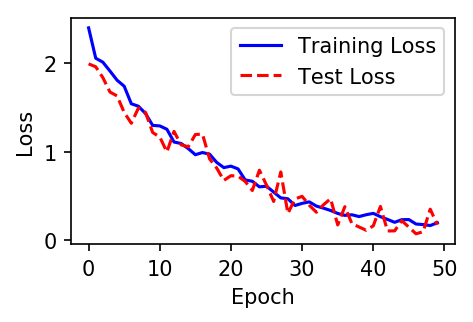

Train accuracy: 0.922
Test accuracy: 0.944


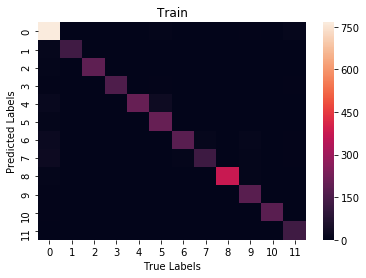

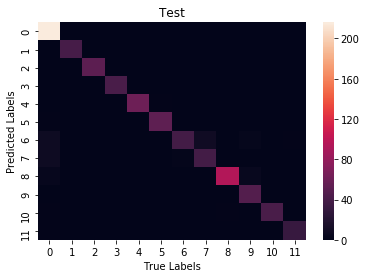

In [16]:
%matplotlib inline

dont_select_zero = False

init_all()
for _ in range(10):
    train_once()

# plot the training process
hmap = np.zeros((nb_outputs, nb_outputs))
hmap_test = np.zeros((nb_outputs, nb_outputs))
    
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist, 'b', label='Training Loss')
plt.plot(loss_hist_test, 'r--', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

sns.despine()
print_accuracy_values()

sns.heatmap(hmap)
plt.title('Train')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.show()
sns.heatmap(hmap_test)
plt.title('Test')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.show()